In [ ]:
# =======================
# Load the MNIST handwritten digit dataset and return DataLoaders for training and testing.
# Each image is converted to a PyTorch tensor and normalized to the [0, 1] range.
# DataLoaders enable efficient batching, shuffling, and iteration during training.
# =======================
from torchvision import datasets, transforms # Import MNIST dataset and image transforms
from torch.utils.data import DataLoader # For batching and loading the dataset

def get_mnist_loaders(batch_size=128):

  # Convert images to PyTorch tensors with values scaled to [0, 1]
  transform = transforms.ToTensor()

  # Download and load the training dataset
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

  # Download and load the test dataset
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Wrap datasets in DataLoaders to enable batching and shuffling
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


In [ ]:
# =======================
# Visualize a batch of MNIST digit images from the training dataset.
# This function loads a mini-batch using get_mnist_loaders() and displays the digits with their labels.
# Useful for quickly inspecting the raw input data before training.
# =======================
import matplotlib.pyplot as plt # For plotting and displaying images
def visualize_batch(batch_size=16):
  # Load a mini-batch of training data
  train_loader, _ = get_mnist_loaders(batch_size)
  images, labels = next(iter(train_loader)) # Get the first batch

  # Create a horizontal grid of images
  plt.figure(figsize=(10, 4))
  for i in range(batch_size):
    plt.subplot(2, batch_size // 2, i + 1) # 2 rows, batch_size/2 columns
    plt.imshow(images[i][0], cmap='gray') # Show the image (channel 0 since MNIST is grayscale)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 622kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.22MB/s]


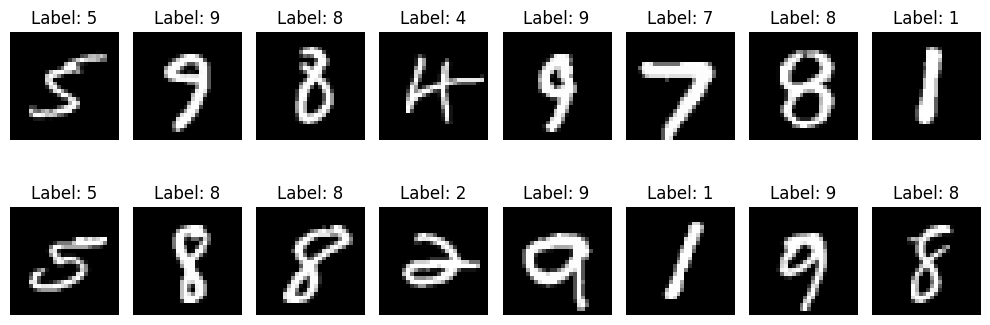

In [ ]:
visualize_batch()

In [ ]:
# Add noise to the image
import torch
import torch.nn as nn

def add_gaussian_noise(x, noise_factor=0.5):
    noise = torch.randn_like(x) * noise_factor
    x_noisy = x + noise
    return torch.clamp(x_noisy, 0., 1.)

def add_masking_noise(x, mask_prob=0.5):
    mask = (torch.rand_like(x) > mask_prob).float()
    return x * mask

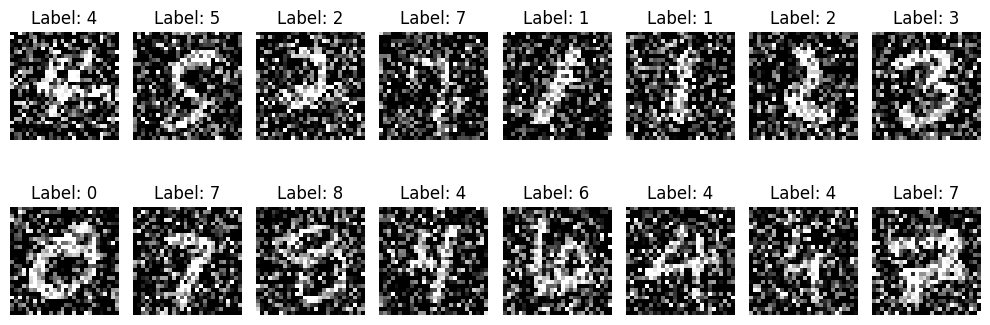

In [ ]:
def visualize_noisy_batch(batch_size=16):
  # Load a mini-batch of training data
  train_loader, _ = get_mnist_loaders(batch_size)
  images, labels = next(iter(train_loader)) # Get the first batch
  images = add_gaussian_noise(images) # add noise to the image
  #images = add_masking_noise(images) # add noise to the image

  # Create a horizontal grid of images
  plt.figure(figsize=(10, 4))
  for i in range(batch_size):
    plt.subplot(2, batch_size // 2, i + 1) # 2 rows, batch_size/2 columns
    plt.imshow(images[i][0], cmap='gray') # Show the image (channel 0 since MNIST is grayscale)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

visualize_noisy_batch()

In [ ]:
# =======================
# Define a fully-connected Autoencoder for compressing and reconstructing MNIST digit images.
# Architecture:
#   Encoder: 784 → 128 → 32
#   Decoder: 32 → 128 → 784
# The model learns to compress 28x28 images into a 32-dimensional latent space and reconstruct them.
# =======================

class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=32):
      super().__init__()

      # Encoder: compress input image to a 32-dimensional latent vector
      self.encoder = nn.Sequential(
          nn.Linear(input_dim, hidden_dim), # Flattened image → hidden layer
          nn.ReLU(),
          nn.Linear(hidden_dim, latent_dim), # Hidden → latent representation
      )

      # Decoder: reconstruct image from the latent vector
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, hidden_dim), # Latent → hidden layer
          nn.ReLU(),
          nn.Linear(hidden_dim, input_dim), # Hidden → reconstructed image
          nn.Sigmoid(),  # Match MNIST pixel range [0, 1]
      )

    def forward(self, x):
      x = x.view(x.size(0), -1) # Flatten image: [batch, 1, 28, 28] → [batch, 784]
      z = self.encoder(x) # Encode to latent vector
      out = self.decoder(z) # Decode back to reconstructed image
      return out

In [ ]:
train_loader, test_loader = get_mnist_loaders()

In [ ]:
# initialize model
model = Autoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
# set up loss function
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
epochs = 10
model.train()
for epoch in range(epochs):
  running_loss = 0.0
  for data in train_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    noisy_inputs = add_gaussian_noise(inputs)
    optim.zero_grad()
    outputs = model(noisy_inputs)
    loss = criterion(outputs, inputs.view(inputs.size(0), -1))
    loss.backward()
    optim.step()
    running_loss += loss.item()
  print(f'Epoch {epoch + 1}/{epochs}, Avg Loss: {running_loss / len(train_loader)}')


Epoch 1/10, Avg Loss: 0.016572071163893254
Epoch 2/10, Avg Loss: 0.016484482414416794
Epoch 3/10, Avg Loss: 0.016438477628949736
Epoch 4/10, Avg Loss: 0.01635536632693208
Epoch 5/10, Avg Loss: 0.01629524039370673
Epoch 6/10, Avg Loss: 0.016260576140540623
Epoch 7/10, Avg Loss: 0.01620900532655688
Epoch 8/10, Avg Loss: 0.016135096077376336
Epoch 9/10, Avg Loss: 0.016106474781230187
Epoch 10/10, Avg Loss: 0.016029552288496417


In [ ]:
# Test the model
model.eval()
with torch.no_grad():
  test_loss = 0.0
  for data in test_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    noisy_inputs = add_gaussian_noise(inputs)
    outputs = model(noisy_inputs)
    loss = criterion(outputs, inputs.view(inputs.size(0), -1))
    test_loss += loss.item()
  print(f'Test Loss: {test_loss / len(test_loader)}')

Test Loss: 0.015781743982453134


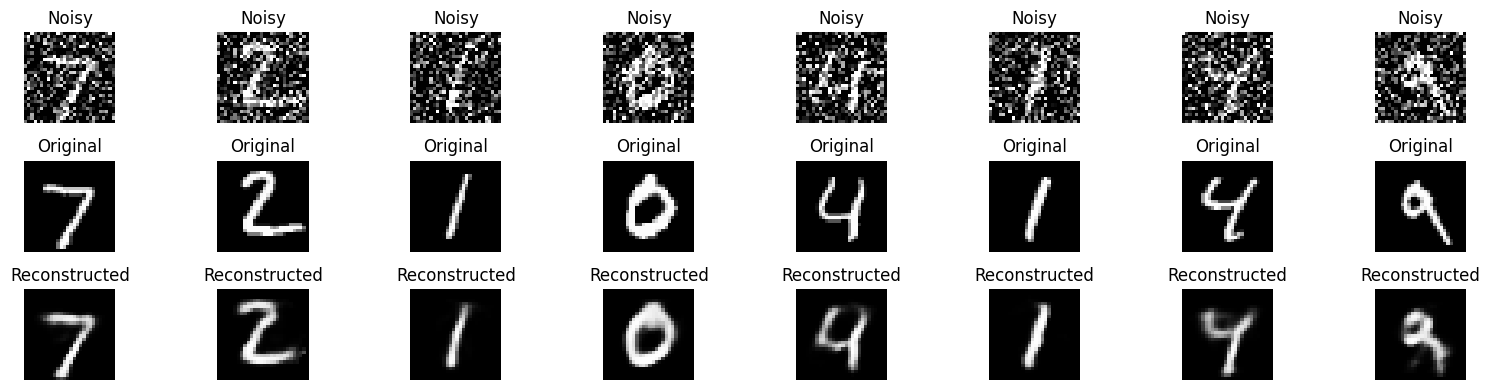

In [ ]:
# Visualize noisy and reconstructed image
model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    noisy_imgs = add_gaussian_noise(sample_imgs)
    noisy_imgs = noisy_imgs.to(device)
    reconstructed = model(noisy_imgs)

# Plot Noisy vs reconstructed
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Noisy
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_imgs[i][0].cpu(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Original
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(sample_imgs[i][0].cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(reconstructed[i].view(28, 28).cpu(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!jupyter nbconvert --to markdown --output=converted_notebook.ipynb Autoencoders.ipynb